In [0]:
# Prog 1
from queue import Queue
from queue import LifoQueue
from queue import PriorityQueue
from random import randint
import numpy as np

class Knight:
    def __init__(self, width, Exp):
        self.width = width
        self.size_board = self.width**2
        self.ways = Exp.ways
        self.get_fitness = Exp.get_fitness
    
    # Function returns route and number of node expanded for specify searching
    # algorithm from start to goal.
    def travel(self, mode, start, goal):
        if start == goal:
            return [start], 0

        if mode == 0:
            return self.BFS(start, goal)
        elif mode == 1:
            # DFS by using DLS without specify max depth.
            return self.DLS(start, goal)
        elif mode == 2:
            return self.IDS(start, goal)
        elif mode == 3:
            # A* by using DLA* without specify max depth.
            return self.DLAs(start, goal)
        elif mode == 4:
            return self.IDAs(start, goal)

    def graph_search(self, start, goal, container,
                     *, max_depth=1e18):
        container.put([start])
        num_expand = 0
        explore_set = set()
        while not container.empty():
            route = container.get()
            u = route[-1]
            explore_set.add(u)
            num_expand += 1
            # Find steps which are available.
            possible_steps = self.possible(route, u)
            # Goal test at node expansion.
            if goal in possible_steps:
                route.append(goal)
                return route, num_expand
            # Add possible steps into explored set if depth <= max depth.
            elif len(route) <= max_depth:
                for v in [x for x in possible_steps if x not in explore_set]:
                    new_route = list(route)
                    new_route.append(v)
                    container.put(new_route)
        return route, num_expand

    def possible(self, route, current):
        ways = self.ways
        steps = [(current[0] + way[0], current[1] + way[1]) for way in ways]
        return [step for step in steps if self.is_available(route, step)]
    
    def is_available(self, route, step):
        return step not in route \
            and 0 <= step[0] and step[0] < self.width \
            and 0 <= step[1] and step[1] < self.width
    
    def BFS(self, start, goal):
        q = Queue()
        return self.graph_search(start, goal, q)

    def DLS(self, start, goal, *, max_depth=1e18):
        q = LifoQueue()
        return self.graph_search(start, goal, q, max_depth=max_depth)

    def IDS(self, start, goal):
        total_expand = 0
        # Iterate through depth and execute DLS.
        for depth in range(1, self.size_board, 1):
            route, num_expand = self.DLS(start, goal, max_depth=depth)
            total_expand += num_expand
            if route[-1] == goal:
                return route, total_expand
        return route, total_expand

    # Graph search with container type of PriorityQueue.
    def graph_search_pq(self, start, goal, container,
                        *, max_depth=1e18):
        init_node = (self.get_fitness((0, list()), start, goal), [start])
        container.put(init_node)
        num_expand = 0
        explore_set = set()
        while not container.empty():
            node = container.get()
            route = node[1]
            u = route[-1]
            explore_set.add(u)
            num_expand += 1
            possible_steps = self.possible(route, u)
            if goal in possible_steps:
                route.append(goal)
                return route, num_expand
            elif len(route) <= max_depth:
                for v in [x for x in possible_steps if x not in explore_set]:
                    new_key = self.get_fitness(node, v, goal)
                    new_route = list(route)
                    new_route.append(v)
                    container.put((new_key, new_route))
        return route, num_expand

    def DLAs(self, start, goal, *, max_depth=1e18):
        pq = PriorityQueue()
        return self.graph_search_pq(start, goal, pq, max_depth=max_depth)

    def IDAs(self, start, goal):
        total_expand = 0
        for depth in range(1, self.size_board, 1):
            route, num_expand = self.DLAs(start, goal, max_depth=depth)
            total_expand += num_expand
            if route[-1] == goal:
                return route, total_expand
        return route, total_expand

    # Test the performance of each method.
    def test(self, iteration, modes):
        expand_hist = np.empty((iteration, len(modes))) # num_expand
        length_hist = np.empty((iteration, len(modes))) # length of route
        for i in range(iteration):
            # Generate start and goal positions randomly.
            start = (randint(0, self.width-1), randint(0, self.width-1))
            goal = (randint(0, self.width-1), randint(0, self.width-1))
            # Test performance of each method on generated start and goal.
            for idx, mode in enumerate(modes):
                route, num_expand = self.travel(mode, start, goal)
                expand_hist[i][idx] = num_expand
                length_hist[i][idx] = len(route)
        return expand_hist, length_hist


## Compare 5 Algorithms

In [0]:
class Control:
    # Ways knight can go.
    ways = [(-2, -1), (-2, 1), (-1, -2), (-1, 2),
            (1, -2), (1, 2), (2, -1), (2, 1)]
    # Fuction calculates key values of PriorityQueue.
    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Control.get_heuristic(current, goal)

    def get_heuristic(current, goal):
        return (abs(current[0]-goal[0]) + abs(current[1]-goal[1])) // 3

iteration = 1000 # Test rounds
np.set_printoptions(precision=2)

board_widths = [8, 10, 12, 14, 16]
modes = range(5)
expand_mean_hist = np.empty((0, len(modes)), float)
length_mean_hist = np.empty((0, len(modes)), float)
for width in board_widths:
    knight = Knight(width, Control)
    expand_hist, length_hist = knight.test(iteration, modes)
    # expand_mean_hist
    expand_mean = expand_hist.mean(axis=0)
    expand_mean_hist = np.append(
        expand_mean_hist,
        np.array([expand_mean]),
        axis=0
    )
    # length_mean_hist
    length_mean = length_hist.mean(axis=0)
    length_mean_hist = np.append(
        length_mean_hist,
        np.array([length_mean]),
        axis=0
    )


### Plot

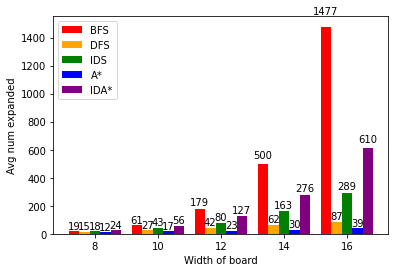

In [123]:
import matplotlib.pyplot as plt

col_count = len(board_widths)
index = np.arange(col_count)
rect_count = len(modes)
bar_width = 1 / (rect_count+1)
xlabels = (width for width in board_widths)
alg_type = ['BFS', 'DFS', 'IDS', 'A*', 'IDA*']

fig = plt.figure()
ax = fig.add_subplot(111)

yvals = expand_mean_hist.T[0]
rects1 = ax.bar(index, yvals, bar_width, color='red')
zvals = expand_mean_hist.T[1]
rects2 = ax.bar(index+bar_width, zvals, bar_width, color='orange')
kvals = expand_mean_hist.T[2]
rects3 = ax.bar(index+bar_width*2, kvals, bar_width, color='green')
lvals = expand_mean_hist.T[3]
rects4 = ax.bar(index+bar_width*3, lvals, bar_width, color='blue')
mvals = expand_mean_hist.T[4]
rects5 = ax.bar(index+bar_width*4, mvals, bar_width, color='purple')

ax.set_ylabel('Avg num expanded')
ax.set_xlabel('Width of board')
ax.set_xticks(index+bar_width*(rect_count//2))
ax.set_xticklabels(xlabels)
ax.legend(
    (rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]),
    (alg for alg in alg_type)
)

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

### Compare Length of Route

In [124]:
import pandas as pd
compare_length = pd.DataFrame(
    length_mean_hist,
    index=board_widths,
    columns=alg_type
)
compare_length

,BFS,DFS,IDS,A*,IDA*
8,3.828,16.092,3.828,3.828,3.828
10,4.332,28.138,4.362,4.332,4.332
12,4.706,42.622,4.774,4.706,4.706
14,5.223,62.483,5.561,5.223,5.223
16,5.705,87.109,6.321,5.705,5.705


In [125]:
compare_length.to_markdown()

'|    |   BFS |    DFS |   IDS |    A* |   IDA* |\n|---:|------:|-------:|------:|------:|-------:|\n|  8 | 3.828 | 16.092 | 3.828 | 3.828 |  3.828 |\n| 10 | 4.332 | 28.138 | 4.362 | 4.332 |  4.332 |\n| 12 | 4.706 | 42.622 | 4.774 | 4.706 |  4.706 |\n| 14 | 5.223 | 62.483 | 5.561 | 5.223 |  5.223 |\n| 16 | 5.705 | 87.109 | 6.321 | 5.705 |  5.705 |'

## A* Experiment

In [0]:
import math

# Change heuristic function
class Exp1:
    ways = Control.ways
    
    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Exp1.get_heuristic(current, goal)
    # Find a straight line distance from current to goal,
    # and calculate steps it takes.
    def get_heuristic(current, goal):
        return math.sqrt((current[0]-goal[0])**2 + (current[1]-goal[1])**2) \
            // math.sqrt(2**2 + 1**2)

class Exp2:
    ways = Control.ways
    
    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Exp2.get_heuristic(current, goal)
    # Find a straight line distance from current to goal,
    # and calculate steps it takes.
    # Also consider the situation that current is too close to goal.
    def get_heuristic(current, goal):
        return (math.sqrt((current[0]-goal[0])**2 + (current[1]-goal[1])**2) \
                - math.sqrt(2**2 + 1**2)) // math.sqrt(2**2 + 1**2)

class Exp3:
    ways = Control.ways

    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Exp3.get_heuristic(current, goal)
    # Find a straight line distance from current to goal directly.
    def get_heuristic(current, goal):
        return math.sqrt((current[0]-goal[0])**2 + (current[1]-goal[1])**2) // 1

class Exp4:
    ways = Control.ways
    
    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Exp4.get_heuristic(current, goal)
    # Find a straight line distance from current to goal directly.
    # Also consider the situation that current is too close to goal.
    def get_heuristic(current, goal):
        return (math.sqrt((current[0]-goal[0])**2 + (current[1]-goal[1])**2) \
            - math.sqrt(2**2 + 1**2)) // 1

### Compare A*

In [0]:
def compareAs(exp_list, board_widths, iteration, *, mode=3):
    expand_mean_hist = np.empty((0, len(exp_list)), float)
    length_mean_hist = np.empty((0, len(exp_list)), float)
    for width in board_widths:
        start_list = np.random.randint(width, size=(iteration, 2))
        goal_list = np.random.randint(width, size=(iteration, 2))
        expand_mean = list()
        length_mean = list()
        for exp in exp_list:
            knight = Knight(width, exp)
            expand_list = np.empty((iteration))
            length_list = np.empty((iteration))
            for i in range(iteration):
                start = (start_list[i][0], start_list[i][1])
                goal = (goal_list[i][0], goal_list[i][0])
                route, num_expand = knight.travel(mode, start, goal)
                expand_list[i] = num_expand
                length_list[i] = len(route)
            expand_mean.append(expand_list.mean())
            length_mean.append(length_list.mean())
        expand_mean_hist = np.append(
            expand_mean_hist,
            np.array([expand_mean]),
            axis=0
        )
        length_mean_hist = np.append(
            length_mean_hist,
            np.array([length_mean]),
            axis=0
        )
    return expand_mean_hist, length_mean_hist

In [128]:
board_widths = [8, 12, 16, 20, 24]
exp_list = [Control, Exp1, Exp2, Exp3, Exp4]
iteration = 1000

expand_mean_hist, length_mean_hist = compareAs(exp_list, board_widths,
                                               iteration)
compare_expand = pd.DataFrame(
    expand_mean_hist,
    index=board_widths,
    columns=['Control', 'Exp1', 'Exp2', 'Exp3', 'Exp4']
)
print(compare_expand)
compare_length = pd.DataFrame(
    length_mean_hist,
    index=board_widths,
    columns=['Control', 'Exp1', 'Exp2', 'Exp3', 'Exp4']
)
print(compare_length)

    Control    Exp1    Exp2    Exp3    Exp4
8    13.319  13.531  13.531   6.942   8.934
12   20.578  20.854  20.854   7.327  10.007
16   35.483  34.462  34.462   8.699  11.893
20   54.251  50.682  50.682   9.502  13.083
24   82.467  72.236  72.236  10.476  14.035
    Control   Exp1   Exp2   Exp3   Exp4
8     3.892  3.892  3.892  3.892  3.892
12    4.632  4.632  4.632  4.632  4.642
16    5.639  5.639  5.639  5.645  5.661
20    6.627  6.627  6.627  6.659  6.665
24    7.430  7.430  7.430  7.484  7.502


## Extra

In [0]:
board_widths = [8, 16, 24]
iteration = 100
expand_list = np.empty((iteration))
length_list = np.empty((iteration))
exp_list = [Control, Exp1, Exp2, Exp3, Exp4]
for width in board_widths:
    expand_mean_hist = list()
    length_mean_hist = list()
    start_list = np.random.randint(width, size=(iteration, 2))
    goal_list = np.random.randint(width, size=(iteration, 2))
    for exp in exp_list:
        knight = Knight(width, exp)
        for i in range(iteration):
            start = (start_list[i][0], start_list[i][1])
            goal = (goal_list[i][0], goal_list[i][1])
            route, num_expand = knight.travel(3, start, goal)
            expand_list[i] = num_expand
            length_list[i] = len(route)
        expand_mean_hist.append(expand_list.mean())
        length_mean_hist.append(length_list.mean())

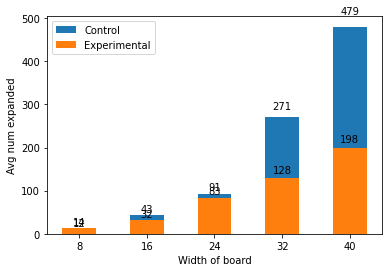

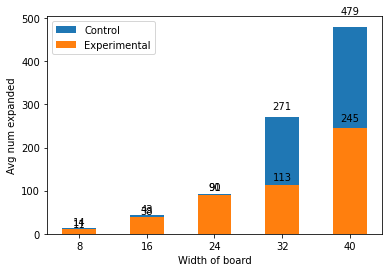

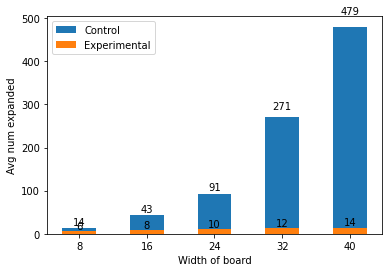

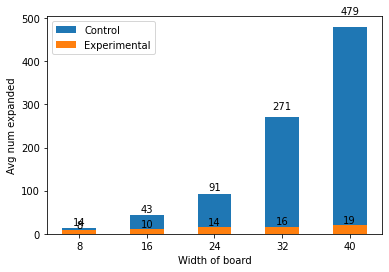

In [130]:
def plot_compare_As(board_widths, control, experimental):
    col_count = len(board_widths)
    index = np.arange(col_count)
    rect_count = 1
    bar_width = 1 / 2
    xlabels = (width for width in board_widths)
    alg_type = ['Control', 'Experimental']

    fig = plt.figure()
    ax = fig.add_subplot(111)

    yvals = control.T[0]
    rects1 = ax.bar(index, yvals, bar_width)
    zvals = experimental.T[0]
    rects2 = ax.bar(index, zvals, bar_width)

    ax.set_ylabel('Avg num expanded')
    ax.set_xlabel('Width of board')
    ax.set_xticks(index+bar_width*(rect_count//2))
    ax.set_xticklabels(xlabels)
    ax.legend(
        (rects1[0], rects2[0]),
        (alg for alg in alg_type)
    )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    return plt

board_widths = [8, 16, 24, 32, 40]
iteration = 100
e0, l0 = exp_on_As(board_widths, iteration, Control)
e1, l1 = exp_on_As(board_widths, iteration, Exp1)
e2, l2 = exp_on_As(board_widths, iteration, Exp2)
e3, l3 = exp_on_As(board_widths, iteration, Exp3)
e4, l4 = exp_on_As(board_widths, iteration, Exp4)

plt = plot_compare_As(board_widths, e0, e1)
plt = plot_compare_As(board_widths, e0, e2)
plt = plot_compare_As(board_widths, e0, e3)
plt = plot_compare_As(board_widths, e0, e4)

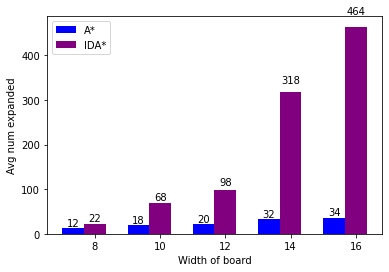

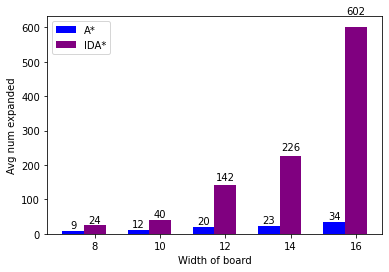

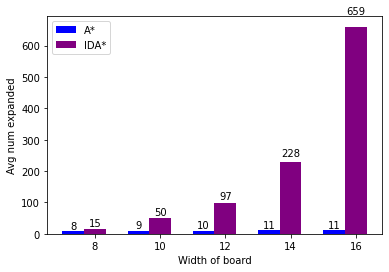

In [131]:
# Evaluation
def exp_on_As_and_IDAs(board_widths, iteration, Exp):
    modes = [3, 4]
    expand_mean_hist = np.empty((0, len(modes)), float)
    length_mean_hist = np.empty((0, len(modes)), float)
    for width in board_widths:
        knight = Knight(width, Exp)
        expand_hist, length_hist = knight.test(iteration, modes)
        # expand_mean_hist
        expand_mean = expand_hist.mean(axis=0)
        expand_mean_hist = np.append(
            expand_mean_hist,
            np.array([expand_mean]),
            axis=0
        )
        # length_mean_hist
        length_mean = length_hist.mean(axis=0)
        length_mean_hist = np.append(
            length_mean_hist,
            np.array([length_mean]),
            axis=0
        )
    return expand_mean_hist, length_mean_hist

# Plot
def plot_expand_As_and_IDAs(board_widths, expand_mean_hist):
    col_count = len(board_widths)
    index = np.arange(col_count)
    rect_count = 2
    bar_width = 1 / (rect_count+1)
    xlabels = (width for width in board_widths)
    alg_type = ['A*', 'IDA*']

    fig = plt.figure()
    ax = fig.add_subplot(111)

    yvals = expand_mean_hist.T[0]
    rects1 = ax.bar(index, yvals, bar_width, color='blue')
    zvals = expand_mean_hist.T[1]
    rects2 = ax.bar(index+bar_width, zvals, bar_width, color='purple')

    ax.set_ylabel('Avg num expanded')
    ax.set_xlabel('Width of board')
    ax.set_xticks(index+bar_width*(rect_count//2))
    ax.set_xticklabels(xlabels)
    ax.legend(
        (rects1[0], rects2[0]),
        (alg for alg in alg_type)
    )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    return plt

# Change heuristic function
class Exp1:
    ways = Control.ways
    
    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Exp1.get_heuristic(current, goal)
    
    def get_heuristic(current, goal):
        return abs(abs(current[0]-goal[0]) + abs(current[1]-goal[1]) - 3) // 3

class Exp2:
    ways = Control.ways
    
    def get_fitness(node, current, goal):
        route = node[1]
        return len(route) + Exp2.get_heuristic(current, goal)
    
    def get_heuristic(current, goal):
        return (math.sqrt((current[0]-goal[0])**2 + (current[1]-goal[1])**2) \
            - math.sqrt(2**2 + 1**2)) // 1

board_widths = [8, 10, 12, 14, 16]
iteration = 100
expand_mean_hist, length_mean_hist = exp_on_As_and_IDAs(board_widths, iteration,
                                                       Control)
plt = plot_expand_As_and_IDAs(board_widths, expand_mean_hist)
plt.show()

expand_mean_hist, length_mean_hist = exp_on_As_and_IDAs(board_widths, iteration,
                                                       Exp1)
plt = plot_expand_As_and_IDAs(board_widths, expand_mean_hist)
plt.show()

expand_mean_hist, length_mean_hist = exp_on_As_and_IDAs(board_widths, iteration,
                                                       Exp2)
plt = plot_expand_As_and_IDAs(board_widths, expand_mean_hist)
plt.show()

In [0]:
# Evaluation
def exp_on_As(board_widths, iteration, Exp):
    modes = [3]
    expand_mean_hist = np.empty((0, len(modes)), float)
    length_mean_hist = np.empty((0, len(modes)), float)
    for width in board_widths:
        knight = Knight(width, Exp)
        expand_hist, length_hist = knight.test(iteration, modes)
        # expand_mean_hist
        expand_mean = expand_hist.mean(axis=0)
        expand_mean_hist = np.append(
            expand_mean_hist,
            np.array([expand_mean]),
            axis=0
        )
        # length_mean_hist
        length_mean = length_hist.mean(axis=0)
        length_mean_hist = np.append(
            length_mean_hist,
            np.array([length_mean]),
            axis=0
        )
    return expand_mean_hist, length_mean_hist

# Plot
def plot_expand_As(board_widths, expand_mean_hist):
    col_count = len(board_widths)
    index = np.arange(col_count)
    rect_count = 1
    bar_width = 1 / (rect_count+1)
    xlabels = (width for width in board_widths)
    alg_type = ['A*']

    fig = plt.figure()
    ax = fig.add_subplot(111)

    yvals = expand_mean_hist.T[0]
    rects1 = ax.bar(index, yvals, bar_width, color='blue')

    ax.set_ylabel('Avg num expanded')
    ax.set_xlabel('Width of board')
    ax.set_xticks(index+bar_width*(rect_count//2))
    ax.set_xticklabels(xlabels)
    ax.legend(
        (rects1[0],),
        ('A*',)
    )

    def autolabel(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                    ha='center', va='bottom')

    autolabel(rects1)

    return plt